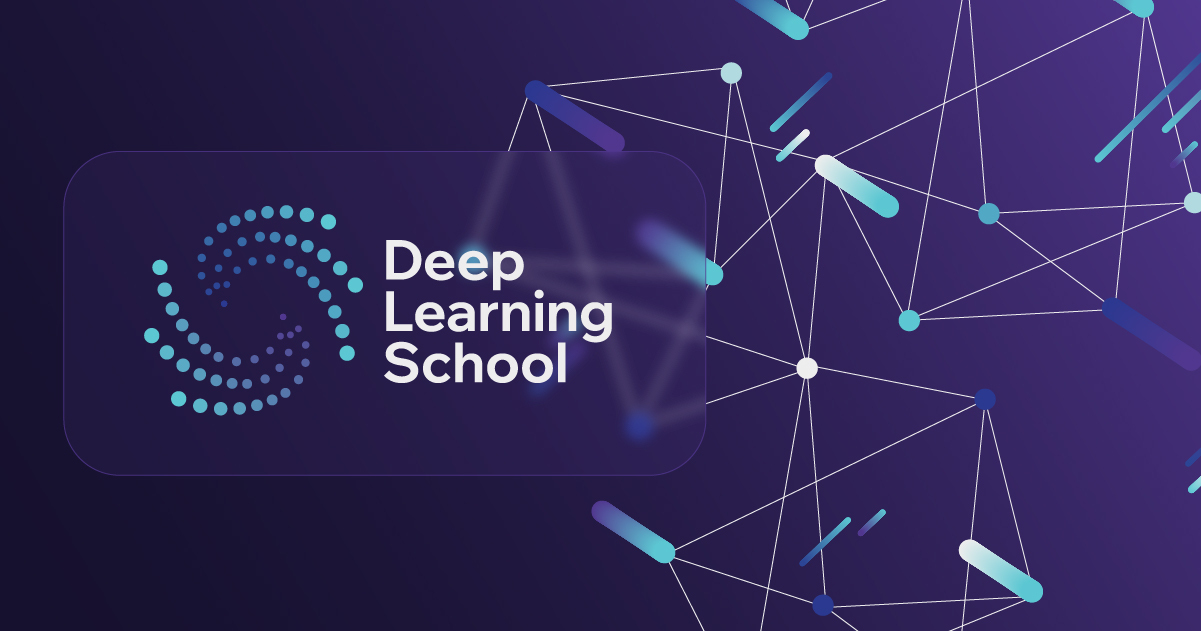

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Детекция объектов</b></h3>

В этом домашнем задании мы продолжим работу над детектором из семинара, поэтому при необходимости можете заимствовать оттуда любой код.

Домашнее задание можно разделить на следующие части:

* Переделываем модель [5]
  * backbone[1],
  * Neck [3],
  * Head [1]
* Label assignment [2]:
  * TAL [2]
* Лоссы [1]:
  * CIoU loss [1]
* Кто больше? [5]
  * 0.15 mAP [1]
  * 0.3 mAP  [2]
  * 0.6 mAP [5]

**Максимальный балл:** 10 баллов. (+3 балла бонус).

In [1]:
import torch
import numpy as np
import pandas as pd
import albumentations as A
import io
import torchvision


from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from albumentations.pytorch.transforms import ToTensorV2

### Загрузка данных

Мы продолжаем работу с датасетом из семинара - Halo infinite ([сслыка](https://universe.roboflow.com/graham-doerksen/halo-infinite-angel-aim)). Загрузка данных и создание датасета полностью скопированы из семинара.

Сначала загружаем данные

In [2]:
splits = {'train': 'data/train-00000-of-00001-0d6632d599c29801.parquet',
          'validation': 'data/validation-00000-of-00001-c6b77a557eeedd52.parquet',
          'test': 'data/test-00000-of-00001-866d29d8989ea915.parquet'}
df_train = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["test"])

Создаем датасет для предобработки данных

In [3]:
class HaloDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        df_objects = pd.json_normalize(dataframe['objects'])[["bbox", "category"]]
        df_images = pd.json_normalize(dataframe['image'])[["bytes"]]
        self.data = dataframe[["image_id"]].join(df_objects).join(df_images)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        import io
        row = self.data.iloc[idx]

        # Загрузка изображения
        image = Image.open(io.BytesIO(row["bytes"])).convert("RGB")
        image = np.array(image)

        # Обработка меток
        labels = [row["category"]] if isinstance(row["category"], int) else row["category"]
        labels = [label - 1 for label in labels]

        # Получение и исправление bbox
        boxes = row["bbox"]

        # Преобразуем из numpy-массива в список списков, если нужно
        if isinstance(boxes, np.ndarray):
            boxes = [b.tolist() for b in boxes]

        # Если один bbox представлен как [x, y, w, h], оборачиваем в список
        if isinstance(boxes, list) and len(boxes) > 0 and isinstance(boxes[0], (int, float)):
            boxes = [boxes]

        # Фильтрация битых боксов
        valid_boxes = []
        valid_labels = []
        for b, l in zip(boxes, labels):
            if isinstance(b, (list, tuple)) and len(b) == 4 and all(isinstance(x, (int, float)) for x in b):
                valid_boxes.append(b)
                valid_labels.append(l)

        # Преобразование в массивы numpy
        boxes = np.array(valid_boxes, dtype=np.float32)
        labels = np.array(valid_labels, dtype=np.int64)

        # Трансформации (если есть)
        if self.transform is not None:
            transformed = self.transform(image=image, bboxes=boxes, labels=labels)
            image = transformed["image"]
            boxes = transformed["bboxes"]
            labels = transformed["labels"]
        else:
            image = transforms.ToTensor()(image)

        # Возврат таргета
        target = {
            "image_id": torch.tensor([row["image_id"]]),
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        return image, target

def collate_fn(batch):
    batch = tuple(zip(*batch))
    images = torch.stack(batch[0])
    return images, batch[1]

Тут можно написать любые аугментации

In [4]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        # Добавляй сюда свои аугментации при необходимости!
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    # Раскомментируй, если аугментации изменяют ббоксы.
    # Не забудь указать верный формат для ббоксов.
    # bbox_params=A.BboxParams(format='coco', label_fields=['labels'])
)

test_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

Не забываем инициализировать наш датасет

In [5]:
train_dataset = HaloDataset(df_train, transform=train_transform)
test_dataset = HaloDataset(df_test, transform=test_transform)

## Переделываем модель [5 баллов]

В семинаре мы реализовали самый базовый детектор, а сейчас настало время его улучшать.

### Backbone [1 балл]

В лекции мы заморозили все слои у модели. Вам нужно написать бекбоун с возможностью разморозки __k__ последних слоев или блоков (на ваш выбор).

In [6]:
import torch.nn as nn
import torchvision.models as models

class Backbone(nn.Module):
    def __init__(self, pretrained=True, unfreeze_last=0):
        super().__init__()
        # Load pretrained ResNet18 model
        self.backbone = models.resnet18(pretrained=pretrained)
        
        # Remove the final FC layer and avgpool
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])
        
        # Get the feature extraction layers
        self.layer0 = nn.Sequential(
            self.backbone[0],  # conv1
            self.backbone[1],  # bn1
            self.backbone[2],  # relu
            self.backbone[3]   # maxpool
        )
        self.layer1 = self.backbone[4]  # layer1
        self.layer2 = self.backbone[5]  # layer2
        self.layer3 = self.backbone[6]  # layer3
        self.layer4 = self.backbone[7]  # layer4
        
        # Freeze all layers initially
        for param in self.parameters():
            param.requires_grad = False
            
        # Unfreeze last k layers if specified
        if unfreeze_last > 0:
            layers_to_unfreeze = [
                self.layer4,
                self.layer3,
                self.layer2,
                self.layer1
            ][:unfreeze_last]
            
            for layer in layers_to_unfreeze:
                for param in layer.parameters():
                    param.requires_grad = True
                    
    def forward(self, x):
        
        # Extract features at different scales
        x0 = self.layer0(x)      # 64 channels
        x1 = self.layer1(x0)     # 64 channels
        x2 = self.layer2(x1)     # 128 channels
        x3 = self.layer3(x2)     # 256 channels
        x4 = self.layer4(x3)     # 512 channels
        
        return [x2, x3, x4]  # Return features from last 3 layers for FPN

### NECK [3 балла]

Вам предлагается на выбор написать одну из двух шей:

#### Feature Pyramid Network [2 балла]

Знакомая из лекции архитектура шеи:

<center><img src="https://user-images.githubusercontent.com/57972646/69858594-b14a6c00-12d5-11ea-8c3e-3c17063110d3.png"/></center>


* [Feature Pyramid Networks for Object Detection](https://arxiv.org/abs/1612.03144)

Она состоит из top-down пути, в котором происходит 2 вещи:
1. Увеличивается пространственная размерность фичей,
2. С помощью скипконнекшеннов, добавляются фичи из backbone модели.

Для увеличения пространственной размерности используется __nearest neighbor upsampling__, а фичи из шеи и бекбоуна суммируются.

#### Path Aggregation Network [3 балла]

Другая архитектура немного сложнее. Она содержит не только top-down путь, но ещё bottom-up путь:

<center><img src="https://i.ibb.co/k68BWBGv/path-aggregation-network.png" width="500"/></center>

* [Path Aggregation Network for Instance Segmentation](https://arxiv.org/abs/1803.01534)

Подробное описание архитектуры можно найти в секции 3 (Framework). Реализовывать adaptive feature pooling не нужно.


__TIPS__:
* Можете использовать базовые классы из лекции,
* Воспользуйтесь AnchorGenerator-ом, чтобы создавать якоря сразу для нескольких выходов,
* Не забудьте использовать nn.ModuleList, если захотите сделать динамическое количество голов у модели,
* Также, можно добавить доп конволюцию (3х3 с паддингом) у каждого выхода шеи.

In [7]:
import torch.nn as nn

class TopDownPath(nn.Module):
    def __init__(self, in_channels=[128, 256, 512], out_channels=256):
        super().__init__()
        self.lateral_convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels[i], out_channels, kernel_size=1),
                nn.ReLU()
            )
            for i in range(len(in_channels))
        ])
        
        self.fpn_convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU()
            )
            for _ in range(len(in_channels))
        ])
        
    def forward(self, features):
        # Convert input features to same channel dimension
        laterals = [
            lateral_conv(feature)
            for feature, lateral_conv in zip(features, self.lateral_convs)
        ]

        # Top-down path
        for i in range(len(laterals) - 1, 0, -1):
            # Upsample higher level feature
            upsampled = nn.functional.interpolate(
                laterals[i], size=laterals[i - 1].shape[-2:], mode='nearest'
            )
            # Add lower level feature
            laterals[i - 1] = laterals[i - 1] + upsampled

        # Apply extra convolutions
        outs = [
            fpn_conv(lateral)
            for lateral, fpn_conv in zip(laterals, self.fpn_convs)
        ]

        return outs

                    

class BottomUpPath(nn.Module):
    def __init__(self, in_channels=256, out_channels=256):
        super().__init__()
        self.downsample = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
                nn.ReLU()
            )
            for _ in range(2)  # 2 downsampling layers for 3 feature levels
        ])
    def forward(self, features):
        results = [features[0]]
        
        # Bottom-up path
        x = features[0]
        for i, down in enumerate(self.downsample):
            # Downsample
            x = down(x)
            # Add feature from same level
            x = x + features[i+1]
            results.append(x)
            
        return results

class Neck(nn.Module):
    def __init__(self, in_channels=[128, 256, 512], out_channels=256):
        super().__init__()
        # Initialize FPN
        self.fpn = TopDownPath(in_channels, out_channels)
        
        # Initialize PAN
        self.pan = BottomUpPath(out_channels, out_channels)
        
    def forward(self, features):
        # Top-down path (FPN)
        fpn_features = self.fpn(features)
        
        # Bottom-up path (PAN)
        final_features = self.pan(fpn_features)
        
        return final_features


### Head [1 балл]

В качестве шеи можно выбрать __один из двух__ вариантов:

#### 1. Decoupled Head

Реализовать Decoupled Head из [YOLOX](https://arxiv.org/abs/2107.08430).
<center><img src="https://i.ibb.co/BVtBR2R3/Decoupled-head.jpg"/></center>

**TIP**: Возьмите за основу голову из семинара, тк она сильно похожа на Decoupled Head.

Изменять количество параметров у шей на разных уровнях не обязательно.

#### 2. Confidence score free head

Нужно взять за основу голову из семинара и полностью убрать предсказание confidence score. Чтобы модель предсказывала только 2 группы: ббоксы и классы.

Есть следующие способы удаления confidence score:
* Добавление нового класса ФОН. Обычно его обозначают нулевым классом.
* Присваивание ббоксам БЕЗ объекта вектор из нулей в качестве таргета.

Выберете тот, который вам больше нравится и будте внимательны при расчете лосса!

**Важно!** Удаление confidence score повлияет на следующие методы из семинара:
* target_assign
* ComputeLoss
* _filter_predictions

In [8]:
class FinalClassification(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        x = self.conv1(x)
        return x


class DecoupledHead(nn.Module):
    def __init__(self, in_channels, num_classes, num_layers=2, hidden_channels = 256):
        super().__init__()
        
        # Shared convolution layers for all heads
        self.shared_conv = nn.Conv2d(in_channels, hidden_channels, kernel_size=1)
        
        # Additional shared layers for reg and obj branches
        self.reg_obj_convs = nn.ModuleList()
        self.cls_convs = nn.ModuleList()
        
        # Build reg & obj shared layers    
        for _ in range(num_layers):
            self.reg_obj_convs.append(
                nn.Sequential(
                    nn.Conv2d(hidden_channels, hidden_channels, 3, padding=1),
                    nn.BatchNorm2d(hidden_channels),
                    nn.ReLU()
                )
            )

            self.cls_convs.append(
                nn.Sequential(
                    nn.Conv2d(hidden_channels, hidden_channels, 3, padding=1),
                    nn.BatchNorm2d(hidden_channels),
                    nn.ReLU()
                )
            )
        
        # Individual FinalClassification layers for each head
        self.cls_final = FinalClassification(in_channels, num_classes)
        self.reg_final = FinalClassification(in_channels, 4)  # x, y, w, h
        self.obj_final = FinalClassification(in_channels, 1)  # objectness score
            
    def forward(self, x):
        # Initial shared convolution
        shared_feat = self.shared_conv(x)
        
        # Process through reg & obj branch
        reg_obj_feat = shared_feat
        for reg_obj_conv in self.reg_obj_convs:
            reg_obj_feat = reg_obj_conv(reg_obj_feat)
            
        # Process through cls branch    
        cls_feat = shared_feat
        for cls_conv in self.cls_convs:
            cls_feat = cls_conv(cls_feat)
            
        # Get final outputs from each head
        cls_out = self.cls_final(cls_feat)
        reg_out = self.reg_final(reg_obj_feat) 
        obj_out = self.obj_final(reg_obj_feat)
        
        return cls_out, reg_out, obj_out

Теперь можно снова реализовать класс детектора с учетом всех частей выше!

In [9]:
class Detector(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        # Backbone from previous cells
        self.backbone = Backbone()
        
        # Neck from previous cells 
        self.neck = Neck()
        
        # Decoupled detection head
        self.head = DecoupledHead(
            in_channels=256,
            num_classes=num_classes
        )
        
    def forward(self, x):
        # Get backbone features
        backbone_feats = self.backbone(x)
        
        # Pass through FPN neck
        neck_feats = self.neck(backbone_feats)
        
        # Pass through detection head
        cls_outs, reg_outs, obj_outs = [], [], []

        for feat in neck_feats:
            cls, reg, obj = self.head(feat)
            cls_outs.append(cls)
            reg_outs.append(reg)
            obj_outs.append(obj)

        return cls_outs, reg_outs, obj_outs



## Label assignment [2]
В этой секции предлагается заменить функцию `assign_target` на более современный алгоритм который называется Task alignment learning.

Он описан в статье [TOOD](https://arxiv.org/abs/2108.07755) в секции 3.2. Для удобства вот его основные шаги:

1. Посчитать значение метрики для каждого предсказанного ббокса:
    
$$t = s^\alpha * u^\beta$$
    
где,
* $s$ — classification score, или вероятность принадлежности предсказанного ббокса к классу реального ббокса (**GT**);
* $u$ — IoU между предсказанным и реальным ббоксами;
* $\alpha,\ \beta$ — нормализационные константы, обычно $\alpha = 6.0, \ \beta = 1.0$.
    
2. Отфильтровать предсказания на основе **GT**.

    Для якорных детекторов, обычно, выбираются только те предсказания, центры якорей которых находятся внутри GT.
4. Для каждого **GT** выбрать несколько (обычно 5 или 13) самых подходящих предсказаний.
5. Если предсказание рассматривается в качестве подходящего для нескольких **GT** — выбрать **GT** с наибольшим пересечением по IoU.


**BAЖНО**: если будете использовать Runner из лекции, не забудьте поменять параметры  в `self.assign_target_method` в методе `_run_train_epoch`.

In [10]:
def box_iou(boxes1, boxes2):
    """
    Calculate IoU between two sets of boxes
    
    Args:
        boxes1: first set of boxes in XYXY format [N, 4]
        boxes2: second set of boxes in XYXY format [M, 4]
    
    Returns:
        IoU matrix [N, M]
    """
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])  # [N]
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])  # [M]
    
    # Get coordinates of intersection boxes
    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]
    
    # Calculate intersection area
    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]
    
    # Calculate union area
    union = area1[:, None] + area2 - inter
    
    return inter / union

def TAL_assigner(pred_cls, pred_reg, gt_boxes, gt_labels, alpha=6.0, beta=1.0, topk=13):
    """
    Task Alignment Learning assigner implementation
    
    Args:
        pred_cls: predicted classification scores [B, num_anchors, num_classes]
        pred_reg: predicted bounding boxes in XYXY format [B, num_anchors, 4] 
        gt_boxes: ground truth boxes in XYXY format [B, max_objects, 4]
        gt_labels: ground truth labels [B, max_objects]
        alpha: normalization constant for classification score
        beta: normalization constant for IoU
        topk: number of predictions to select per GT
        
    Returns:
        assigned_gt_inds: indices of assigned GT boxes for each prediction
        pos_mask: binary mask of positive samples
    """
    batch_size = pred_cls.shape[0]
    num_preds = pred_cls.shape[1]
    
    device = pred_cls.device
    assigned_gt_inds = torch.zeros((batch_size, num_preds), dtype=torch.long, device=device)
    pos_mask = torch.zeros((batch_size, num_preds), dtype=torch.bool, device=device)
    
    for b in range(batch_size):
        # Get valid GT boxes (remove padding)
        valid_mask = gt_boxes[b].sum(dim=1) > 0
        cur_gt_boxes = gt_boxes[b][valid_mask]
        cur_gt_labels = gt_labels[b][valid_mask]
        
        if len(cur_gt_boxes) == 0:
            continue
            
        # Calculate IoU between predictions and GT boxes
        ious = box_iou(pred_reg[b], cur_gt_boxes)  # [num_preds, num_gts]
        
        # Get classification scores for each GT's class
        pred_scores = pred_cls[b]  # [num_preds, num_classes]
        gt_class_scores = pred_scores[:, cur_gt_labels]  # [num_preds, num_gts]
        
        # Calculate alignment metric
        alignment = torch.pow(gt_class_scores, alpha) * torch.pow(ious, beta)  # [num_preds, num_gts]
        
        # Get topk predictions for each GT
        topk_metrics, topk_idxs = alignment.topk(min(topk, num_preds), dim=0)  # [topk, num_gts]
        
        # Assign GT index to each selected prediction
        for gt_idx in range(len(cur_gt_boxes)):
            pred_idxs = topk_idxs[:, gt_idx]
            
            # If prediction is already assigned to another GT,
            # keep the one with higher IoU
            for pred_idx in pred_idxs:
                if pos_mask[b, pred_idx]:
                    prev_gt_idx = assigned_gt_inds[b, pred_idx]
                    if ious[pred_idx, gt_idx] > ious[pred_idx, prev_gt_idx]:
                        assigned_gt_inds[b, pred_idx] = gt_idx
                else:
                    pos_mask[b, pred_idx] = True
                    assigned_gt_inds[b, pred_idx] = gt_idx
                    
    return assigned_gt_inds, pos_mask




### DIoU [1]

Вместо SmoothL1, который используется в семинаре, реализуем лосс, основанный на пересечении ббоксов. В качестве тренировки давайте напишем Distance Intersection over Union (DIoU).

<center><img src=https://wikidocs.net/images/page/163613/Free_Fig_5.png></center>

Для его реализации разобъем задачу на части:

**1. Реализуем IoU:**

Пусть даны координаты для предсказанного ($B^p$) и истинного ($B^g$) ббоксов в формате XYXY или VOC PASCAL (левый верхний и правый нижний углы):

$B^p=(x^p_1, y^p_1, x^p_2, y^p_2)$, $B^g=(x^g_1, y^g_1, x^g_2, y^g_2)$, тогда алгоритм расчета будет следующий:

    1. Найдем площади обоих ббоксов:
$$ A^p = (x^p_2 - x^p_1) * (y^p_2 - y^p_1) $$
$$ A^g = (x^g_2 - x^g_1) * (y^g_2 - y^g_1) $$

    2. Посчитаем пересечение между ббоксами:

Тут мы предлагаем вам подумать как в общем виде можно расчитать размеры ббокса, который будет являться пересечением $B^p$ и $B^g$, а затем посчитать его площадь:

$$x^I_1 = \qquad \qquad y^I_1 = $$
$$x^I_2 = \qquad \qquad y^I_2 = $$

В общем виде, площать будет записываться следующим образом:

Если $x^I_2 > x^I_1$ & $y^I_2 > y^I_1$, тогда:

$$I = (x^I_2 - x^I_1) * (y^I_2 - y^I_1)$$

Иначе, $I = 0$.

    3. Считаем объединение ббоксов.

Мы можем посчитать эту площадь как сумму площадей двух ббоксов минус площадь пересечения (тк мы считаем её два раз в сумме площадей):

$$U = A^p + A^g - I$$

    4. Вычисляем IoU.

$$IoU = \frac{I}{U}$$

**2. Рассчитаем площадь выпуклой оболочки:**

Для расчета площади, сначала выпишите координаты верхнего левого и правого нижнего углов. Подумайте, чему будут равны эти координаты в общем случае?

$$x^С_1 = \qquad \qquad y^С_1 = $$
$$x^С_2 = \qquad \qquad y^С_2 = $$

Подсказка: Нарисуйте несколько вариантов пересечений предсказания и GT на бумажке, и выпишите координаты для выпуклой оболочки.

$$C = (x^C_2 - x^C_1) * (y^C_2 - y^C_1)$$

**3. Рассчитаем расстояние между цетрами ббоксов:**

Сначала находим координаты центров каждого из ббоксов (если ббоксы в формате YOLO, то и считать ничего не нужно), затем считаем Евклидово расстояние между центрами.

$d = $

Собираем все части вместе и считаем лосс по формуле:

$$ DIoU = 1 - IoU + \frac{d^2}{C^2}$$

Помните, что пар ббоксов может быть много! Возвращайте усредненное значение лосса.

In [11]:
from torchvision.ops import distance_box_iou_loss

In [12]:
def gen_bbox(num_boxes=10):
    min_corner = torch.randint(0, 100, (num_boxes, 2))
    max_corner = torch.randint(50, 150, (num_boxes, 2))

    for i in range(2):
        wrong_order = min_corner[:, i] > max_corner[:, i]
        if wrong_order.any():
            min_corner[wrong_order, i], max_corner[wrong_order, i] = max_corner[wrong_order, i], min_corner[wrong_order, i]
    return torch.cat((min_corner, max_corner), dim=1)

In [13]:
pred_boxes = gen_bbox(num_boxes=100)
true_boxes = gen_bbox(num_boxes=100)

In [14]:
print(f" DIoU: {distance_box_iou_loss(pred_boxes, true_boxes, reduction='mean').item()}")

 DIoU: 1.0279779434204102


In [15]:
def diou_loss(pred_boxes, gt_boxes):
    """
    pred_boxes, gt_boxes: [N, 4] — (x1, y1, x2, y2), нормализованные
    """
    px1, py1, px2, py2 = pred_boxes[:, 0], pred_boxes[:, 1], pred_boxes[:, 2], pred_boxes[:, 3]
    gx1, gy1, gx2, gy2 = gt_boxes[:, 0], gt_boxes[:, 1], gt_boxes[:, 2], gt_boxes[:, 3]

    # Intersection
    ix1 = torch.max(px1, gx1)
    iy1 = torch.max(py1, gy1)
    ix2 = torch.min(px2, gx2)
    iy2 = torch.min(py2, gy2)

    iw = (ix2 - ix1).clamp(min=0)
    ih = (iy2 - iy1).clamp(min=0)
    inter_area = iw * ih

    # Union
    area_p = (px2 - px1).clamp(min=0) * (py2 - py1).clamp(min=0)
    area_g = (gx2 - gx1).clamp(min=0) * (gy2 - gy1).clamp(min=0)
    union_area = area_p + area_g - inter_area

    iou = inter_area / (union_area + 1e-7)

    # DIoU penalty term
    px = (px1 + px2) / 2
    py = (py1 + py2) / 2
    gx = (gx1 + gx2) / 2
    gy = (gy1 + gy2) / 2

    center_dist = (px - gx)**2 + (py - gy)**2

    enclose_x1 = torch.min(px1, gx1)
    enclose_y1 = torch.min(py1, gy1)
    enclose_x2 = torch.max(px2, gx2)
    enclose_y2 = torch.max(py2, gy2)
    enclose_diag = (enclose_x2 - enclose_x1)**2 + (enclose_y2 - enclose_y1)**2 + 1e-7

    diou = iou - center_dist / enclose_diag
    loss = 1 - diou  # want to maximize diou ⇒ minimize 1 - diou

    return loss.mean()  # ⬅️ вернёт grad-enabled scalar



In [16]:
import numpy as np
pred_boxes = gen_bbox(num_boxes=1000)
true_boxes = gen_bbox(num_boxes=1000)

# проверим что написанный лосс выдает те же результаты что и лосс из торча.
assert np.isclose(diou_loss(pred_boxes, true_boxes), distance_box_iou_loss(pred_boxes, true_boxes, reduction="mean"))

## Кто больше? [5 баллов]

Наконец то мы дошли до самый интересной части. Тут мы раздаем очки за mAP'ы!

Все что вы написали выше вам поможет улучшить качество итогового детектора, настало время узнать насколько сильно :)

За достижения порога по mAP на тестовом наборе вы получаете баллы:
* 0.15 mAP [1]
* 0.3 mAP [2]
* 0.6 mAP [5]


**TIPS**:
1. На семинаре мы специально не унифицировали формат ббоксов между методами, чтобы обратить ваше внимание что за этим нужно следить. Чтобы было проще, сразу унифицируете формат по всему ноутбуку. Советуем использовать формат xyxy, тк IoU и NMS из torch используют именно этот формат. (Не забудьте поменять формат у таргета в `HaloDataset`).
2. Попробуйте перейти к IoU-based лоссу при обучении. То есть обучать не смещения, а сразу предсказывать ббокс.
3. Поэксперементируйте с подходами target assignment'а в процессе обучения. Например, можно на первых итерациях использовать обычный метод, а затем подключить TAL.
4. Добавьте аугментаций!

   Можно взять [albumentations](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/), библиотеку, которую мы использовали всеминаре. Или базовые аугментации из торча [тык](https://pytorch.org/vision/main/transforms.html). Если будете использовать торч, не забудте про ббоксы, transforms из коробки не будет их агументировать.
7. Попробуйте добавлять различные блоки из YOLO архитектур в шею вместо единичных конволюционных слоев. (Например, замените конволюции 3х3 на CSP блоки).
8. Попробуйте заменить NMS на другой метод (WeightedNMS, SoftNMS, etc.). Немного ссылок:
    * Статья про SoftNMS [тык](https://arxiv.org/pdf/1704.04503)
    * Статья про WeightedNMS [тык](https://openaccess.thecvf.com/content_ICCV_2017_workshops/papers/w14/Zhou_CAD_Scale_Invariant_ICCV_2017_paper.pdf)
    * Есть их реализация, правда на нумбе [git](https://github.com/ZFTurbo/Weighted-Boxes-Fusion?tab=readme-ov-file)
10. Не бойтесь эксперементировать и удачи!

Также, напишите развернутые ответы на следующие вопросы:

**Questions:**
1. Какой метод label assignment'a помогает лучше обучаться модели? Почему?
2. Какое из сделаных вами улучшений внесло наибольший вклад в качество модели? Как вы думаете, почему это произошло?
3. Какое из сделанных вами улучшений вообще не изменило метрику? Как вы думаете, почему это произошло?

In [17]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)



In [18]:
print(len(train_loader))

29


In [19]:
# def inspect_dataframe_for_invalid_bboxes(df):
#     bad_rows = []

#     for idx, row in df.iterrows():
#         bbox = row.get("objects", {}).get("bbox", None)

#         # Проверка: есть ли bbox вообще
#         if bbox is None:
#             bad_rows.append((idx, "bbox is None"))
#             continue

#         # Если bbox — одиночный список
#         if isinstance(bbox, list) and all(isinstance(x, (int, float)) for x in bbox):
#             if len(bbox) != 4:
#                 bad_rows.append((idx, f"Single bbox has wrong length: {len(bbox)}"))
#             continue

#         # Если bbox — список списков
#         if isinstance(bbox, list) and isinstance(bbox[0], (list, tuple)):
#             for i, b in enumerate(bbox):
#                 if not (isinstance(b, (list, tuple)) and len(b) == 4 and all(isinstance(x, (int, float)) for x in b)):
#                     bad_rows.append((idx, f"bbox[{i}] is malformed: {b}"))
#             continue

#         # Новый случай: bbox — это numpy массив массивов
#         if isinstance(bbox, np.ndarray):
#             try:
#                 for i, b in enumerate(bbox):
#                     if not (isinstance(b, (np.ndarray, list, tuple)) and len(b) == 4 and all(isinstance(x, (int, float, np.float32, np.int64)) for x in b)):
#                         bad_rows.append((idx, f"bbox[{i}] is malformed: {b}"))
#             except Exception as e:
#                 bad_rows.append((idx, f"Error parsing ndarray: {e}"))
#             continue

#         # Если ничего не подошло
#         bad_rows.append((idx, f"Unknown bbox type: {type(bbox)} - {bbox}"))

#     print(f"Найдено {len(bad_rows)} проблемных строк.")
#     for idx, reason in bad_rows[:10]:
#         print(f"[{idx}] {reason}")

#     return bad_rows
# bad = inspect_dataframe_for_invalid_bboxes(df_train)

In [34]:
import torch.nn.functional as F

def postprocess_predictions(cls_outs, reg_outs, obj_outs, conf_thresh=0.5, iou_thresh=0.5, image_size=640):
    # Пример обработки выхода с одного уровня (последнего)
    cls_out = cls_outs[-1]  # [B, C, H, W]
    reg_out = reg_outs[-1]  # [B, 4, H, W]
    obj_out = obj_outs[-1]  # [B, 1, H, W]
    print(cls_out.shape)
    print(reg_out.shape)
    print(obj_out.shape)
    B, C, H, W = cls_out.shape
    results = []

    for b in range(B):
        scores = torch.sigmoid(cls_out[b]) * torch.sigmoid(obj_out[b])
        scores, labels = scores.max(dim=0)  # [H, W]
        boxes = reg_out[b].permute(1, 2, 0).reshape(-1, 4)  # [H*W, 4]
        scores = scores.reshape(-1)  # [H*W]
        labels = labels.reshape(-1)  # [H*W]

        # Фильтрация по порогу
        mask = scores > conf_thresh
        boxes = boxes[mask]
        scores = scores[mask]
        labels = labels[mask]

        if boxes.numel() == 0:
            results.append({"boxes": torch.empty((0, 4)), "scores": torch.empty(0), "labels": torch.empty(0, dtype=torch.long)})
            continue

        # Преобразование координат (если они в offsets или центре)
        boxes = box_cxcywh_to_xyxy(boxes)  # если ты так обучаешь

        # Масштабирование в пиксели (если нужно)
        H, W = image_size
        boxes[:, [0, 2]] *= W  # x1, x2
        boxes[:, [1, 3]] *= H  # y1, y2

        # NMS
        keep = torchvision.ops.nms(boxes, scores, iou_thresh)
        results.append({
            "boxes": boxes[keep],
            "scores": scores[keep],
            "labels": labels[keep]
        })

    return results


In [35]:
def pairwise_iou(boxes1, boxes2):
    # boxes: [N, 4], [M, 4] (x1, y1, x2, y2)
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N, M, 2]
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N, M, 2]

    wh = (rb - lt).clamp(min=0)  # [N, M, 2]
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N, M]

    union = area1[:, None] + area2 - inter
    iou = inter / (union + 1e-6)
    return iou  # [N, M]

def greedy_diou_loss(pred_boxes, gt_boxes, iou_threshold=0.1):
    if len(pred_boxes) == 0 or len(gt_boxes) == 0:
        return torch.tensor(0.0, device=pred_boxes.device, requires_grad=True)

    ious = pairwise_iou(pred_boxes, gt_boxes)  # [N_pred, N_gt]
    matched_gt = set()
    loss = None
    matched = 0

    for i in range(len(pred_boxes)):
        iou_row = ious[i]
        max_iou, j = torch.max(iou_row, dim=0)

        if max_iou > iou_threshold and j.item() not in matched_gt:
            l = diou_loss(pred_boxes[i].unsqueeze(0), gt_boxes[j].unsqueeze(0))
            if loss is None:
                loss = l
            else:
                loss += l
            matched_gt.add(j.item())
            matched += 1

    if matched == 0:
        return torch.tensor(0.0, device=pred_boxes.device, requires_grad=True)

    return loss / matched




In [36]:
from torchmetrics.detection import MeanAveragePrecision
import tqdm


def box_cxcywh_to_xyxy(boxes):
    """
    Преобразует боксы из формата (cx, cy, w, h) → (x1, y1, x2, y2)
    """
    cx, cy, w, h = boxes.unbind(-1)
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    return torch.stack([x1, y1, x2, y2], dim=-1)


def validate(model, dataloader, filter_predictions_func, box_format='xyxy', device='cpu',
             score_threshold=0.05, nms_threshold=0.5, **kwargs):
    model.eval()
    metric = MeanAveragePrecision(box_format=box_format, iou_type="bbox")
    
    for i, (images, targets) in enumerate(tqdm.tqdm(dataloader, desc="Running validation", leave=False)):
        images = images.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            cls_outs, reg_outs, obj_outs = model(images)
            predicts = filter_predictions_func(
                cls_outs, reg_outs, obj_outs,
                conf_thresh=score_threshold,
                iou_thresh=nms_threshold,
                image_size=images.shape[2:]  # (H, W)
            )

        # ⬇️ Отладочная печать — один раз в начале
        if i == 0:
            for j, (pred, gt) in enumerate(zip(predicts, targets)):
                print(f"\n🔍 Sample {j}")
                print(f"Pred boxes:  {pred['boxes'].cpu().numpy()}")
                print(f"GT boxes:    {gt['boxes'].cpu().numpy()}")
                print(f"Pred scores: {pred['scores'].cpu().numpy()}")
                print(f"Pred labels: {pred['labels'].cpu().numpy()}")
                print(f"GT labels:   {gt['labels'].cpu().numpy()}")

        metric.update(predicts, targets)

    return metric.compute()["map"].item()








In [37]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

def denormalize(img_tensor, mean, std):
    """Обратная нормализация изображения"""
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img_tensor * std + mean

def visualize_detections(model, dataloader, device, class_names=None, mean=[0.5]*3, std=[0.5]*3, epoch=0):
    model.eval()
    images, targets = next(iter(dataloader))
    image = images[0].to(device).unsqueeze(0)

    with torch.no_grad():
        cls_outs, reg_outs, obj_outs = model(image)

    # Предположим, что postprocess_predictions вернёт детекции в виде списка словарей {'boxes': ..., 'labels': ..., 'scores': ...}
    detections = postprocess_predictions(cls_outs, reg_outs, obj_outs)[0]

    # Обратная нормализация и преобразование в PIL
    image_denorm = denormalize(images[0].cpu(), mean, std)
    image_denorm = torch.clamp(image_denorm, 0, 1)
    img = F.to_pil_image(image_denorm)

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)

    # Ground truth боксы — красные
    for box in targets[0]['boxes']:
        x1, y1, x2, y2 = box.cpu().numpy()
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Предсказания — зелёные
    for box in detections['boxes']:
        x1, y1, x2, y2 = box.cpu().numpy()
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

    ax.set_title(f'Detections at Epoch {epoch}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


Epoch 1/100: 100%|██████████| 29/29 [00:17<00:00,  1.67it/s, loss=0.7841]



Epoch [1/100], Average Loss: 2.2525


Running validation:   0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([16, 4, 20, 20])
torch.Size([16, 4, 20, 20])
torch.Size([16, 1, 20, 20])

🔍 Sample 0
Pred boxes:  [[ 1.63688696e+03  9.91474609e+02  3.09435669e+02  2.46025116e+02]
 [ 3.08680878e+02  5.71479614e+02 -2.99959656e+02 -3.07311157e+02]
 [ 2.34610205e+03  8.68623169e+02  4.55214905e+02 -6.51799393e+01]
 [ 2.40737671e+03  9.37489624e+02  2.82269897e+02 -3.59499359e+01]
 [ 2.27518286e+03  1.01034851e+03  2.34615021e+02  8.09379578e+00]
 [ 4.26263306e+02  6.74061584e+02 -2.66597931e+02 -1.95224182e+02]
 [ 2.59437402e+03  1.02470520e+03  3.83503662e+02 -4.04790878e+01]
 [ 2.75668188e+03  8.28757263e+02  2.03014450e+02 -1.58153839e+02]
 [ 2.31480322e+03  1.24820532e+03  1.04329453e+02 -2.21481750e+02]
 [ 2.79867065e+03  8.79355713e+02  3.60754547e+02 -1.16184845e+02]
 [ 2.45940161e+03  1.01285773e+03  4.90978394e+02 -2.53645325e+01]
 [-6.23833275e+01  4.79852295e+02 -5.23409668e+02 -1.33057724e+02]
 [-5.12683105e+01  4.59490051e+02 -5.00327118e+02 -1.74466370e+02]
 [ 2.82584253e+03  7

c:\Users\Mishele Dolmin\CODE\DLS\.venv\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)
Running validation:  11%|█         | 1/9 [00:00<00:03,  2.22it/s]

GT boxes:    [[354. 264.  42.  48.]
 [310. 264. 146. 250.]]
Pred scores: [0.47310483 0.42439005 0.41866967 0.38401136 0.37686393 0.37681177
 0.3699859  0.36907947 0.36431983 0.3607992  0.3607536  0.35260433
 0.35151705 0.35149246 0.34655815 0.33887988 0.33859885 0.33775353
 0.3350728  0.33373094 0.3300172  0.3257216  0.3251796  0.32484558
 0.32366127 0.31984028 0.31655547 0.31648338 0.31474656 0.31465095
 0.31060737 0.3086527  0.30560416 0.30513605 0.3042525  0.30277565
 0.30126965 0.30047482 0.30025402 0.30013052 0.298951   0.29458895
 0.29242247 0.28722402 0.2872065  0.2833647  0.2832487  0.28091487
 0.28054678 0.27502206 0.27393264 0.2736659  0.27323726 0.27166635
 0.2706938  0.26948717 0.2602939  0.25842255 0.25829303 0.25537375
 0.2529343  0.25195548 0.2516643  0.24615432 0.24608465 0.24316922
 0.2431682  0.23958264 0.23931822 0.23924637 0.23485789 0.22982988
 0.2253755  0.22453791 0.21762119 0.21617678 0.21262538 0.21246752
 0.21182619 0.21116593 0.20990737 0.20583333 0.20461892 

Running validation:  22%|██▏       | 2/9 [00:00<00:02,  2.53it/s]

torch.Size([16, 4, 20, 20])
torch.Size([16, 4, 20, 20])
torch.Size([16, 1, 20, 20])


Running validation:  33%|███▎      | 3/9 [00:01<00:02,  2.66it/s]

torch.Size([16, 4, 20, 20])
torch.Size([16, 4, 20, 20])
torch.Size([16, 1, 20, 20])


Running validation:  44%|████▍     | 4/9 [00:01<00:01,  2.73it/s]

torch.Size([16, 4, 20, 20])
torch.Size([16, 4, 20, 20])
torch.Size([16, 1, 20, 20])


Running validation:  56%|█████▌    | 5/9 [00:01<00:01,  2.76it/s]

torch.Size([16, 4, 20, 20])
torch.Size([16, 4, 20, 20])
torch.Size([16, 1, 20, 20])


Running validation:  67%|██████▋   | 6/9 [00:02<00:01,  2.80it/s]

torch.Size([16, 4, 20, 20])
torch.Size([16, 4, 20, 20])
torch.Size([16, 1, 20, 20])


Running validation:  78%|███████▊  | 7/9 [00:02<00:00,  2.81it/s]

torch.Size([16, 4, 20, 20])
torch.Size([16, 4, 20, 20])
torch.Size([16, 1, 20, 20])


Running validation:  89%|████████▉ | 8/9 [00:02<00:00,  2.80it/s]

torch.Size([16, 4, 20, 20])
torch.Size([16, 4, 20, 20])
torch.Size([16, 1, 20, 20])


torch.Size([8, 4, 20, 20])
torch.Size([8, 4, 20, 20])
torch.Size([8, 1, 20, 20])


Validation mAP: 0.0000
torch.Size([1, 4, 20, 20])
torch.Size([1, 4, 20, 20])
torch.Size([1, 1, 20, 20])


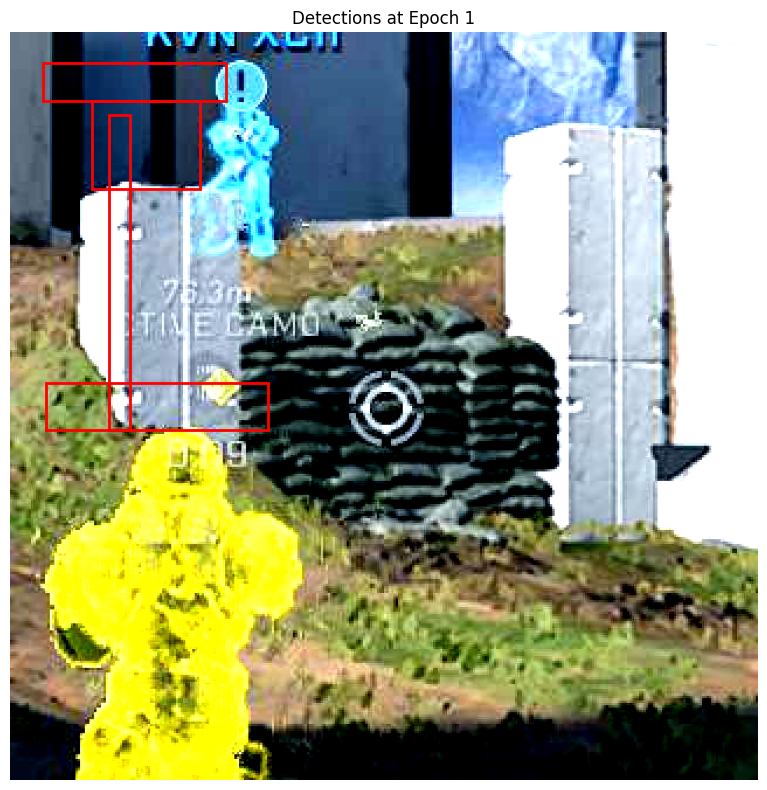

Epoch 2/100: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s, loss=0.9190]



Epoch [2/100], Average Loss: 0.9237


Running validation:   0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([16, 4, 20, 20])
torch.Size([16, 4, 20, 20])
torch.Size([16, 1, 20, 20])

🔍 Sample 0
Pred boxes:  [[ 1.70064148e+03  9.80796387e+02  3.51198730e+02  1.66129913e+02]
 [ 2.64721100e+02  6.68574219e+02 -3.13408051e+02 -2.13733276e+02]
 [ 2.25412769e+03  8.71802429e+02  2.43098297e+02 -1.04023361e+02]
 [ 2.40456152e+03  8.82325928e+02  3.45787292e+02 -4.70283890e+01]
 [ 2.36676367e+03  9.84643677e+02  5.12463135e+02  3.42119217e+01]
 [ 2.68056201e+03  8.41439087e+02  3.14825073e+02 -1.69099731e+02]
 [ 2.76744385e+03  9.14328857e+02  4.04205078e+02  2.94370270e+01]
 [ 2.93151733e+03  7.57186829e+02  3.62472687e+02 -1.63576279e+02]
 [ 2.59517212e+03  1.17175159e+03  4.35267395e+02  9.19943237e+01]
 [ 2.79309692e+03  8.60513000e+02  4.20964600e+02 -2.92991638e+01]
 [ 6.00930725e+02  8.39040405e+02 -1.98106064e+02 -1.32974854e+02]
 [ 2.98338574e+03  7.63162781e+02  3.20072174e+02 -1.95882874e+02]
 [ 3.06480103e+03  6.95501404e+02  3.51500854e+02 -3.13901093e+02]
 [ 2.78672266e+03  1

Running validation:  11%|█         | 1/9 [00:00<00:03,  2.10it/s]


Pred scores: [0.4928678  0.44611043 0.44593948 0.44508275 0.42330423 0.40371314
 0.3961382  0.39158392 0.38277814 0.38144132 0.378019   0.37599045
 0.3739936  0.37213084 0.36665264 0.36644304 0.36533496 0.36449936
 0.36393216 0.36129716 0.36036876 0.35671014 0.35341182 0.34925702
 0.34904817 0.34701255 0.34564832 0.34502643 0.3431883  0.34205145
 0.34182814 0.34136426 0.34062788 0.3400828  0.339341   0.33855504
 0.33807316 0.33714685 0.3367845  0.33656225 0.3340092  0.3338891
 0.33157238 0.3305542  0.3299366  0.32991418 0.3294604  0.32713997
 0.32647252 0.32534796 0.32514516 0.32487527 0.32481357 0.32148644
 0.31977358 0.31895876 0.31635126 0.3162251  0.31376484 0.31369746
 0.31166053 0.31122893 0.30961603 0.30940625 0.30863008 0.30627993
 0.30376408 0.30012733 0.295326   0.2946409  0.29374182 0.29373965
 0.2936202  0.293537   0.29304746 0.2924074  0.29201865 0.29027665
 0.28933463 0.28702402 0.28600013 0.2850976  0.2847629  0.28461662
 0.28417587 0.28022546 0.2785367  0.2758352  0.27

Running validation:  22%|██▏       | 2/9 [00:00<00:02,  2.44it/s]

torch.Size([16, 4, 20, 20])
torch.Size([16, 4, 20, 20])
torch.Size([16, 1, 20, 20])


Running validation:  33%|███▎      | 3/9 [00:01<00:02,  2.61it/s]

torch.Size([16, 4, 20, 20])
torch.Size([16, 4, 20, 20])
torch.Size([16, 1, 20, 20])


Running validation:  44%|████▍     | 4/9 [00:01<00:01,  2.71it/s]

torch.Size([16, 4, 20, 20])
torch.Size([16, 4, 20, 20])
torch.Size([16, 1, 20, 20])


Running validation:  56%|█████▌    | 5/9 [00:01<00:01,  2.76it/s]

torch.Size([16, 4, 20, 20])
torch.Size([16, 4, 20, 20])
torch.Size([16, 1, 20, 20])


Running validation:  67%|██████▋   | 6/9 [00:02<00:01,  2.77it/s]

torch.Size([16, 4, 20, 20])
torch.Size([16, 4, 20, 20])
torch.Size([16, 1, 20, 20])


Running validation:  78%|███████▊  | 7/9 [00:02<00:00,  2.83it/s]

torch.Size([16, 4, 20, 20])
torch.Size([16, 4, 20, 20])
torch.Size([16, 1, 20, 20])


Running validation:  89%|████████▉ | 8/9 [00:02<00:00,  2.83it/s]

torch.Size([16, 4, 20, 20])
torch.Size([16, 4, 20, 20])
torch.Size([16, 1, 20, 20])


torch.Size([8, 4, 20, 20])
torch.Size([8, 4, 20, 20])
torch.Size([8, 1, 20, 20])


Validation mAP: 0.0000
torch.Size([1, 4, 20, 20])
torch.Size([1, 4, 20, 20])
torch.Size([1, 1, 20, 20])


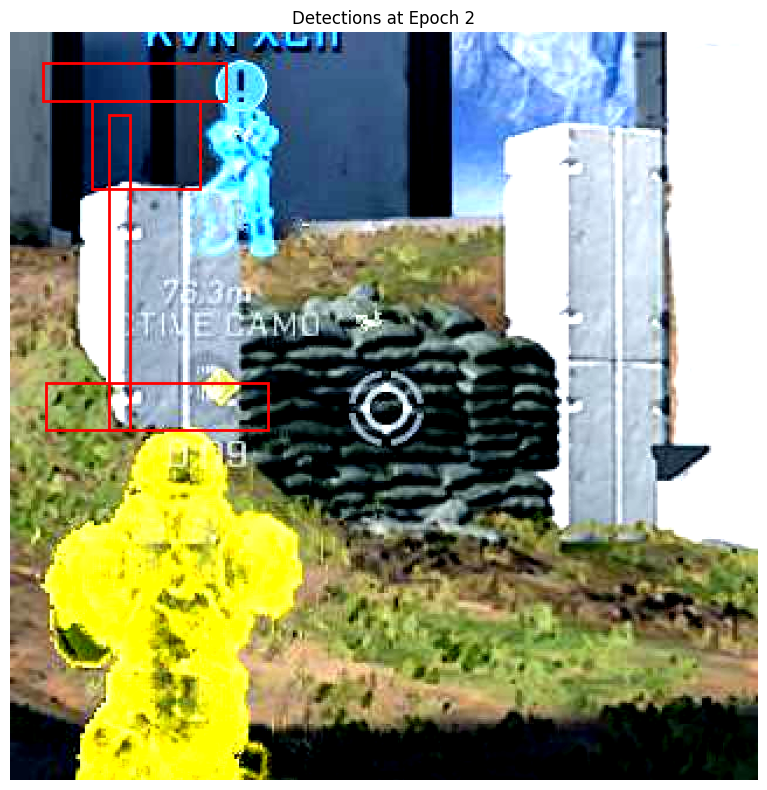

Epoch 3/100:   7%|▋         | 2/29 [00:01<00:21,  1.26it/s, loss=0.8551]


KeyboardInterrupt: 

In [38]:
import tqdm
import torch

# Training configuration
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
detector = Detector(num_classes=4).to(device)
optimizer = torch.optim.Adam(detector.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5
)

best_map = 0.0

for epoch in range(num_epochs):
    detector.train()
    epoch_loss = 0.0
    progress_bar = tqdm.tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for images, targets in progress_bar:
        images = images.to(device)
        # гарантируем, что у каждого target есть keys 'boxes' и 'labels'
        # и переносим на device
        targets = [
            {
                'boxes': t['boxes'].to(device) if t['boxes'].numel() else t['boxes'].to(device).view(0,4),
                'labels': t['labels'].to(device) if t['labels'].numel() else t['labels'].to(device).view(0)
            }
            for t in targets
        ]

        # Forward
        cls_outs, reg_outs, obj_outs = detector(images)

        # Собираем предсказания из последнего уровня
        B = images.size(0)
        pred_cls = cls_outs[-1].permute(0,2,3,1).reshape(B, -1, 4)
        pred_reg = reg_outs[-1].permute(0,2,3,1).reshape(B, -1, 4)
        pred_reg = (pred_reg + 1) * (640.0 / 2.0)  # в координаты изображения

        # Собираем GT-боксы и метки, паддим нулями
        max_objects = max([t['boxes'].size(0) for t in targets] + [0])
        gt_boxes  = torch.zeros(B, max_objects, 4, device=device)
        gt_labels = torch.zeros(B, max_objects, dtype=torch.long, device=device)
        for i, t in enumerate(targets):
            n = t['boxes'].size(0)
            if n > 0:
                gt_boxes[i, :n]  = t['boxes']
                gt_labels[i, :n] = t['labels']

        # Assign positive anchors через TAL_assigner
        assigned_gt_inds, pos_mask = TAL_assigner(
            pred_cls, pred_reg, gt_boxes, gt_labels
        )

        # Вычисляем DIoU-регрессионный лосс по положительным примерам
        total_loss = 0.0
        for b in range(B):
            pos = pos_mask[b]
            if pos.sum() == 0:
                continue
            pred_boxes   = pred_reg[b][pos]
            gt_idx_for_b = assigned_gt_inds[b][pos]
            target_boxes = gt_boxes[b][gt_idx_for_b]
            total_loss  = total_loss + diou_loss(pred_boxes, target_boxes)
        total_loss = total_loss / B

        # Backprop
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
        progress_bar.set_postfix({'loss': f'{total_loss.item():.4f}'})

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f'\nEpoch [{epoch+1}/{num_epochs}], Average Loss: {avg_epoch_loss:.4f}')

    # Validation
    val_map = validate(
        model=detector,
        dataloader=test_loader,
        filter_predictions_func=postprocess_predictions,
        device=device
    )
    print(f'Validation mAP: {val_map:.4f}')

    scheduler.step(avg_epoch_loss)
    visualize_detections(
        model=detector, dataloader=test_loader, device=device, epoch=epoch+1
    )

    if val_map > best_map:
        best_map = val_map
        torch.save(detector.state_dict(), 'best_detector.pth')
        print(f'New best mAP: {best_map:.4f}, model saved!')


Ниже определена вспомогательная функция для валидации качества. Можете использовать `Runner.validate`. Важное уточнение, ей нужен метод для фильтрации предсказаний. Можете тоже скопировать его из семинара, если он у вас не менялся.

In [ ]:
# Получим один батч
images, targets = next(iter(train_loader))

# 1. Размер входного изображения
print("🔹 Input tensor shape:", images.shape)  # [B, C, H, W]

# 2. Размеры оригинальных изображений, если есть
if 'orig_size' in targets[0]:
    print("🔸 Original image size:", targets[0]['orig_size'])
elif 'size' in targets[0]:
    print("🔸 Image size (in target):", targets[0]['size'])
else:
    print("⚠️ Target does not contain original image size")

# 3. Прогон через модель
detector.eval()
with torch.no_grad():
    cls_outs, reg_outs, obj_outs = detector(images.to(device))

# 4. Статистика по регрессии
reg_sample = reg_outs[-1]  # последняя фича
print("🧊 reg_outs[-1].shape:", reg_sample.shape)

sample_values = reg_sample[0].permute(1, 2, 0).reshape(-1, 4)
print("📦 reg_outs sample stats:")
print("   min:", sample_values.min().item())
print("   max:", sample_values.max().item())
print("   mean:", sample_values.mean().item())


In [ ]:
cls_outs, reg_outs, obj_outs = detector(images.to(device))
predictions = postprocess_predictions(cls_outs, reg_outs, obj_outs, conf_thresh=0.5)
print(predictions[0])


In [ ]:
import numpy as np
from termcolor import colored
from collections import defaultdict

def beautiful_int(i):
    i = str(i)
    return ".".join(reversed([i[max(j, 0):j+3] for j in range(len(i) - 3, -3, -3)]))

def model_num_params(model, verbose_all=False, verbose_only_learnable=False):
    sum_params = 0
    sum_learnable_params = 0
    submodules = defaultdict(lambda: [0, 0])
    for name, param in model.named_parameters():
        num_params = np.prod(param.shape)
        # Убираем дебажный print(param)
        if verbose_all or (verbose_only_learnable and param.requires_grad):
            print(
                colored(
                    f"{name: <42} ~  {beautiful_int(num_params): <9} params ~ grad: {param.requires_grad}",
                    "green" if param.requires_grad else "red",
                )
            )
        sum_params += num_params
        sm = name.split(".")[0]
        submodules[sm][0] += num_params
        if param.requires_grad:
            sum_learnable_params += num_params
            submodules[sm][1] += num_params

    print(
        f'\nIn total:\n'
        f'  - {beautiful_int(sum_params)} params\n'
        f'  - {beautiful_int(sum_learnable_params)} learnable params'
    )
    for sm, (total, learnable) in submodules.items():
        print(
            f"\n . {sm}:\n"
            f" .   - {beautiful_int(total)} params\n"
            f" .   - {beautiful_int(learnable)} learnable params"
        )

    return sum_params, sum_learnable_params

# Теперь можно вызывать без ошибок:
sum_params, sum_learnable_params = model_num_params(detector, verbose_only_learnable=True)
